In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')
    source('../utils_mapping.R')
    source('../utils_plotting.R')
})


# R1C8a

"3. A recent benchmarking study found that Harmony underperforms at preserving biologic variability. (Leuecken et al. (https://doi.org/10.1101/2020.05.22.111161), 2020). Here the authors modify the integrative analysis to specifically remove "the effect of donor and tissue" which might easily lead to over-integration and masking of biological variability between cell populations."


STRATEGY: 
- Harmony on both donor and tissue is consistent with Harmony on donors alone 
- We tried integration with alternative popular integration algorithms, some of which were highly ranked in "bio-preservation" scores in Leuecken et al: Scanorama, BBKNN, scVI, and Seurat v3 multiCCA. 

RESPONSE: 

Incorrectly merging distinct cellular phenotypes is always a potential problem with any integration algorithm. The benchmarking study in Lecken et al therefore studied this potential in multiple datasets. While their discussion warns that Harmony has the propensity to "over-integrate", 




# Consistency with donor-only Harmony

## Load

In [4]:
obj <- list()
obj$meta_data <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/meta_data.rds')
obj$V <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/V.rds')



## Harmony

In [5]:
do_harmony <- function(obj, vars, n_rounds=10, keep_intermediate=TRUE, ...) {

    if (keep_intermediate) {
        obj$.Z_cos <- list()
        obj$.Z_corr <- list()
        obj$.R <- list()
        obj$.betas <- list()

        hres <- HarmonyMatrix(
            obj$V, obj$meta_data, vars, 
            do_pca = FALSE, 
            max.iter.harmony = 1, 
            return_object = TRUE,
            ...
        )
        
        obj$.Z_cos[[1]] <- hres$Z_cos
        obj$.Z_corr[[1]] <- hres$Z_corr
        obj$.R[[1]] <- hres$R
        obj$.betas[[1]] <- harmony:::moe_ridge_get_betas(hres)
        for (iter in seq(2, n_rounds)) {
            harmony:::harmonize(hres, 1)
            obj$.Z_cos[[iter]] <- hres$Z_cos
            obj$.Z_corr[[iter]] <- hres$Z_corr
            obj$.R[[iter]] <- hres$R
            obj$.betas[[iter]] <- harmony:::moe_ridge_get_betas(hres)
        }  
        obj$Z_cos <- obj$.Z_cos[[n_rounds]]
        obj$Z_corr <- obj$.Z_corr[[n_rounds]]
        obj$R <- obj$.R[[n_rounds]]
        obj$betas <- obj$.betas[[n_rounds]]
        
    } else {
        hres <- HarmonyMatrix(
            obj$V, obj$meta_data, vars, 
            do_pca = FALSE, 
            max.iter.harmony = n_rounds, 
            return_object = TRUE,
            ...
        )
        obj$Z_cos <- hres$Z_cos
        obj$Z_corr <- hres$Z_corr
        obj$R <- hres$R
        obj$betas <- harmony:::moe_ridge_get_betas(hres)
    }
    
    obj$kmeans_rounds <- hres$kmeans_rounds
    obj$objective_kmeans <- hres$objective_kmeans
    obj$use_weights <- hres$use_weights
    obj$weights <- hres$weights
    
    return(obj)
}

In [ ]:
set.seed(1)
fig.size(3, 5)
t_harmony <- system.time({
    obj <- do_harmony(
        obj, 
        c('LibraryID'), 
        theta = c(2), 
        tau = 5, ## at least 5 cells per cluster (still way too many for lung)
#         theta = c(0.25, 0.25), 
#         lambda = c(1, 2),
        weights = obj$meta_data$weight, 
        ## do lots of iterations - we can wait 
#         max.iter.harmony=5, max.iter.cluster=10,
        n_rounds=10, keep_intermediate=TRUE, max.iter.cluster=100, 
        epsilon.harmony = -Inf, epsilon.cluster = -Inf
    )
})
t_harmony



use_weights



[1] TRUE


use_weights

use_weights



[1] TRUE


use_weights

Harmony 1/1



In [ ]:
t_harmony[['elapsed']] / 60

In [ ]:
fig.size(3, 5)
harmony:::HarmonyConvergencePlot(obj)

fig.size(5, 12)
harmony:::HarmonyConvergencePlot(obj) + 
    facet_wrap(~harmony_idx, scales = 'free', nrow = 2) + 
        NULL


In [ ]:
plan(multicore)
system.time({
    obj$.U <- obj$.Z_cos %>% map(t) %>% future_map(do_umap, .spread = 1.0, .min_dist = 0.3)    
})


In [ ]:
fig.size(6, 12)
# obj$.U %>% map('embedding') %>% map(dim)
obj$.U %>% map('embedding') %>% map(do_scatter, obj$meta_data, 'Tissue') %>% reduce(`+`)

In [ ]:
fig.size(6, 12)
# obj$.U %>% map('embedding') %>% map(dim)
do_scatter(obj$.U[[10]]$embedding, obj$meta_data, 'Tissue', quo(Tissue), nrow=2, palette_use=palette_global) + 
#     facet_wrap(~Tissue) + 
    NULL

In [ ]:
fig.size(6, 12)
# obj$.U %>% map('embedding') %>% map(dim)
do_scatter(obj$.U[[10]]$embedding, obj$meta_data, 'Cluster', quo(Tissue), nrow=2, palette_use=palette_global, do_labels=FALSE) + 
#     facet_wrap(~Tissue) + 
    NULL

In [ ]:
saveRDS(obj$.U[[10]]$embedding, '/data/srlab2/ik936/Roche/data/cache/harmony_over_donors_umap.rds')

## Figure

In [ ]:
U <- readRDS('/data/srlab2/ik936/Roche/data/cache/harmony_over_donors_umap.rds')

In [ ]:
p1 <- do_scatter(U, obj$meta_data, 'Tissue', quo(Tissue), nrow=2, palette_use=palette_global, do_labels=FALSE)

In [ ]:
p2 <- do_scatter(U, obj$meta_data, 'Cluster_name', palette_use=palette_global, do_labels=FALSE, no_guides=FALSE) +
    geom_density_2d() 

In [ ]:
fig.size(5, 12)
p1 + p2 + plot_annotation(tag_levels = 'a') + plot_layout(widths = c(1.2, 1))

# All Epithelial cells



## Load data

In [2]:
system.time({
    dname <- '/data/srlab2/ik936/Roche/data/cache/all_obj_all/'
    fields_load <- c('meta_data', 'exprs_raw')
#     fields_load <- c('meta_data', 'exprs_raw', 'umap_after', 'umap_before', 'V', 'Z_corr')
    obj_all <- map(fields_load, function(name) {
        readRDS(file.path(dname, paste0(name, '.rds')))
    })
    names(obj_all) <- fields_load

    
})


   user  system elapsed 
 19.289   1.741  23.299 

## Get Epithelial cells

In [3]:
meta_data <- obj_all$meta_data %>% 
    subset(Tissue %in% c('Lung', 'SalivaryGland', 'Gut')) %>% 
    subset(joint_lineage == 'epithelial')
nrow(meta_data)


y <- factor(meta_data$Tissue)
w <- as.numeric((1 / prop.table(table(y)))[y]) / nlevels(y)
meta_data$weight <- w


[1] 21155

## Do harmony

In [4]:
set.seed(1)
obj <- create_object(
    obj_all$exprs_raw[, meta_data$CellID], 
    meta_data, 
    npcs=50, 
    split_vargenes_by='Tissue', 
    verbose=TRUE
)



start filter

start normalization



   user  system elapsed 
  6.530   3.915  10.533 


Finished normalization

start vargenes



   user  system elapsed 
  5.346   2.584   7.970 


Finished vargenes

start pca



   user  system elapsed 
239.521  29.237  20.811 


Finished PCA



In [5]:
obj$umap_before <- do_umap(obj$V, .spread=1, .min_dist = .5)$embedding

use_weights



[1] TRUE


use_weights

use_weights



[1] TRUE


use_weights

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



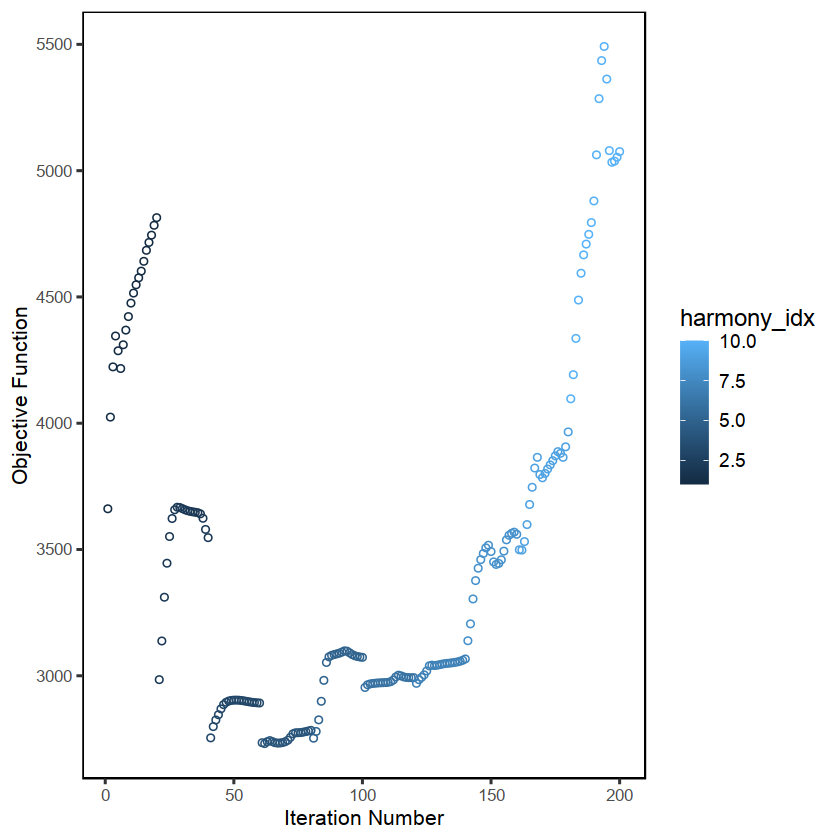

In [6]:
set.seed(1)
obj <- do_harmony(
    obj, 
    c('LibraryID', 'Tissue'), 
    theta = c(0.3, 0.2), 
    weights = obj$meta_data$weight, 
    ## do lots of iterations - we can wait 
        max.iter.harmony=10, max.iter.cluster=20,
#     n_rounds=5, keep_intermediate=TRUE, max.iter.cluster=30, 
    epsilon.harmony = -Inf, epsilon.cluster = -Inf,
    plot_convergence = TRUE
)




In [7]:
obj$umap_after <- do_umap(t(obj$Z_corr), .spread=1, .min_dist = .5)$embedding

## Figures

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


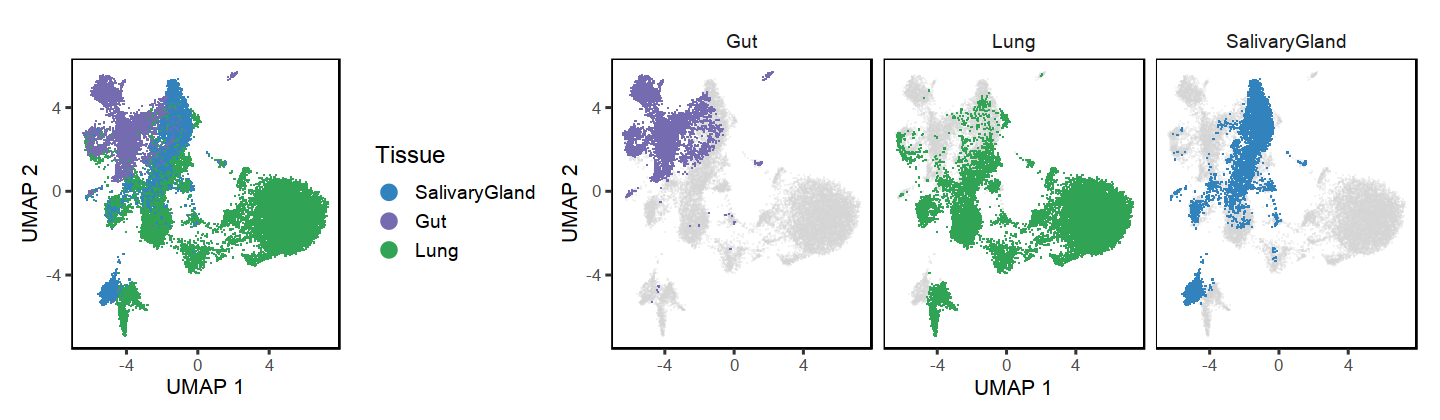

In [15]:
fig.size(3.5, 12)
do_scatter(obj$umap_after, obj$meta_data, 'Tissue', palette_use = palette_global[obj$meta_data$Tissue], do_labels = FALSE, no_guides = FALSE) + 
do_scatter(obj$umap_after, obj$meta_data, 'Tissue', quo(Tissue), palette_use = palette_global[obj$meta_data$Tissue], do_labels = FALSE, no_guides = TRUE) + 
plot_layout(widths = c(1, 3))



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


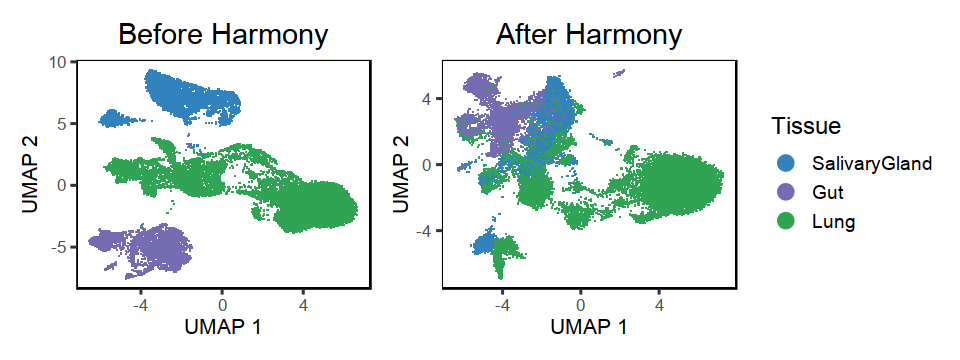

In [14]:
fig.size(3, 8)
do_scatter(obj$umap_before, obj$meta_data, 'Tissue', palette_use = palette_global[obj$meta_data$Tissue], do_labels = FALSE, no_guides = TRUE) + 
    labs(title = 'Before Harmony') + 
do_scatter(obj$umap_after, obj$meta_data, 'Tissue', palette_use = palette_global[obj$meta_data$Tissue], do_labels = FALSE, no_guides = FALSE) + 
    labs(title = 'After Harmony') + 
NULL


In [10]:
## Now cluster 
res <- kmeans(obj$V, 100, iter.max = 30)$cluster


In [11]:
## The distance between cells in one cluster is larger for fibroblasts

## Fibroblasts
idx <- which(res == 10)
.d <- dist(t(obj$Z_cos)[idx, ])
quantile(as.numeric(.d), c(.5, .95, 1))


50%       95%      100% 
0.2930673 0.4453329 0.7126554

In [12]:
dists <- split(seq_len(length(res)), res) %>% 
    map_dbl(function(idx) {
        mean(as.numeric(dist(t(obj$Z_cos)[idx, ])))
    })

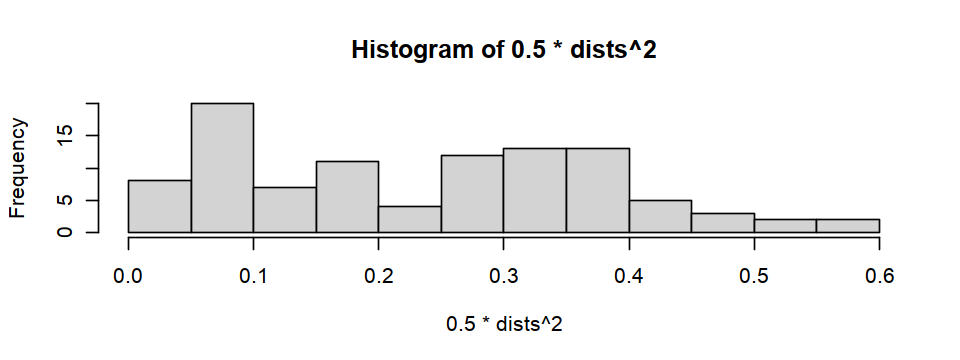

In [13]:
## Fibros
hist(.5 * dists^2)

## Cache

In [16]:
saveRDS(obj, '/data/srlab2/ik936/Roche/data/cache/R1C08_obj_epithelial.rds')

# Epithelial + Fibroblast (negative control)

In [6]:
with(obj_all$meta_data, table(Tissue, joint_lineage))

               joint_lineage
Tissue          endothelial epithelial fibroblast glial lymphoid mural myeloid
  Gut                  4226       4098      11131   920      107  1023       1
  Lung                 7998      13011       1710   406    29856   838   40768
  SalivaryGland        5653       4046       7692   406     9209  2535     937
  Synovium            18154          0      47849     0        0  1982       0
               joint_lineage
Tissue          plasma
  Gut              631
  Lung             432
  SalivaryGland   5677
  Synovium           0

In [7]:
meta_data <- obj_all$meta_data %>% 
    subset(
        (Tissue == 'Synovium' & joint_lineage == 'fibroblast') | 
        (Tissue == 'Lung' & joint_lineage == 'epithelial')
    ) %>% 
    group_by(Tissue) %>% 
    dplyr::sample_n(10000L) %>% 
    dplyr::ungroup() %>% 
    dplyr::select(-weight)
    

## PCA

In [8]:
set.seed(1)
system.time({
    obj <- create_object(
        obj_all$exprs_raw[, meta_data$CellID], 
        meta_data, 
        npcs=20, 
        split_vargenes_by='Tissue', 
        verbose=TRUE
    )    
})


start filter

Warning message in create_object(obj_all$exprs_raw[, meta_data$CellID], meta_data, :
“weights not initialized in metadata. Setting all to 1.”
start normalization



   user  system elapsed 
  4.643   3.344   8.078 


Finished normalization

start vargenes



   user  system elapsed 
  3.762   2.217   6.034 


Finished vargenes

start pca



   user  system elapsed 
 51.354  18.278  11.384 


Finished PCA



   user  system elapsed 
 61.869  26.069  29.821 

In [9]:
system.time({
    obj$umap_before <- do_umap(obj$V, .spread=1, .min_dist = .5)$embedding    
})


   user  system elapsed 
 18.586   0.198  12.802 

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


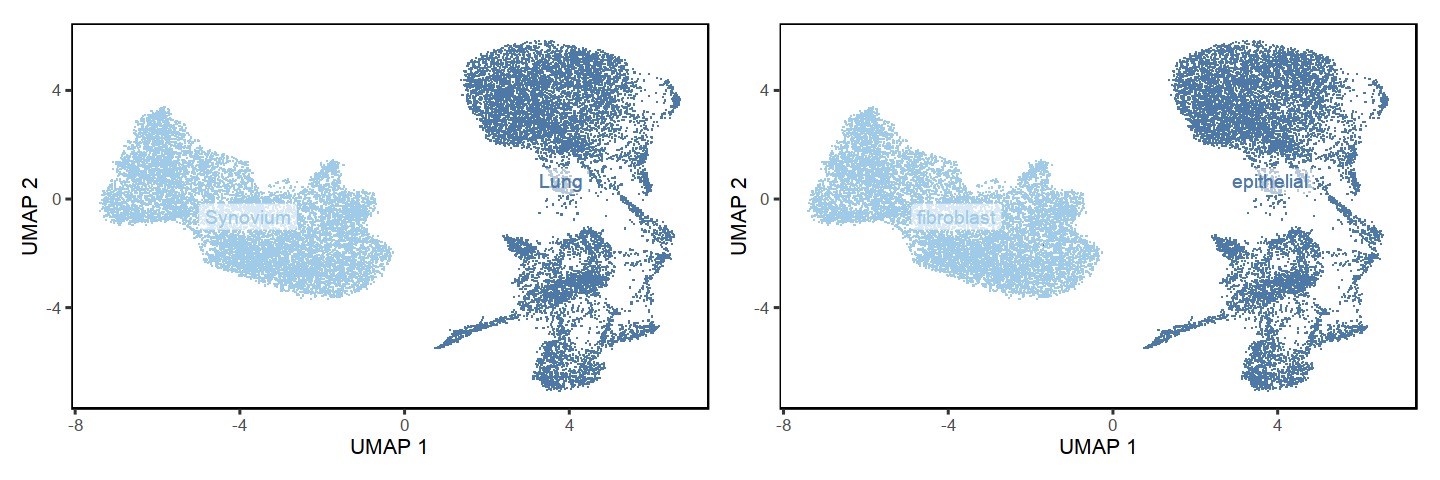

In [10]:
fig.size(4, 12)
do_scatter(obj$umap_before, obj$meta_data, 'Tissue', ) + 
do_scatter(obj$umap_before, obj$meta_data, 'joint_lineage') + 
NULL


## Harmony

use_weights



[1] TRUE


use_weights

use_weights



[1] TRUE


use_weights

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



    user   system  elapsed 
2381.477 4071.775  291.288 

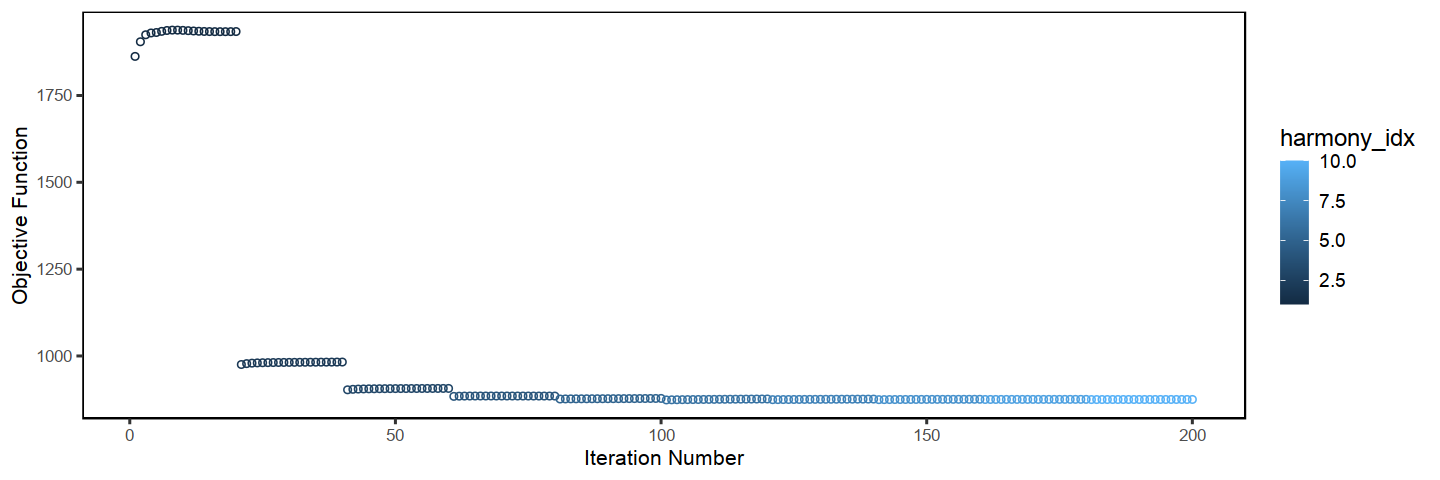

In [11]:
set.seed(1)
system.time({
    obj <- do_harmony(
        obj, 
        c('LibraryID', 'Tissue'), 
        theta = c(0.3, 0.2), 
        sigma = 0.05, ## Changed this based on autopsy results below 
        weights = obj$meta_data$weight, 
        ## do lots of iterations - we can wait 
            max.iter.harmony=10, max.iter.cluster=20,
    #     n_rounds=5, keep_intermediate=TRUE, max.iter.cluster=30, 
        epsilon.harmony = -Inf, epsilon.cluster = -Inf,
        plot_convergence = TRUE
    )
})


In [12]:
system.time({
    obj$umap_after <- do_umap(t(obj$Z_corr), .spread=1, .min_dist = .5)$embedding    
})


   user  system elapsed 
 17.884   0.066  12.040 

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


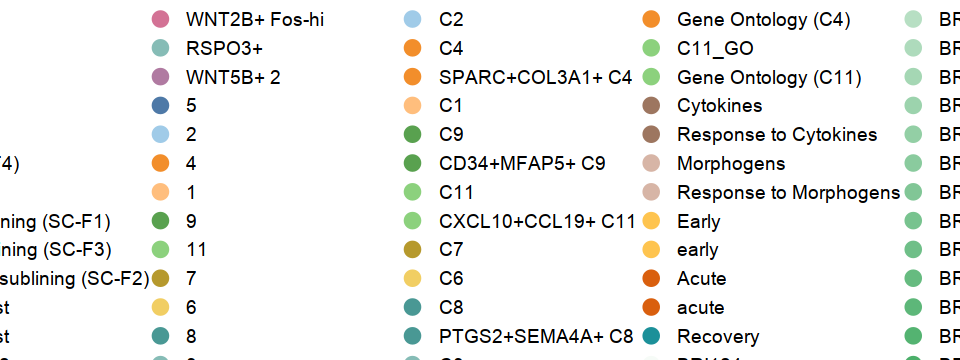

In [13]:
fig.size(3, 8)
do_scatter(obj$umap_before, obj$meta_data, 'Tissue', palette_use = palette_global, do_labels = FALSE, no_guides = TRUE) + 
    labs(title = 'Before Harmony') + 
do_scatter(obj$umap_after, obj$meta_data, 'Tissue', palette_use = palette_global, do_labels = FALSE, no_guides = FALSE) + 
    labs(title = 'After Harmony') + 
# do_scatter(obj$umap_after, obj$meta_data, 'joint_lineage', palette_use = palette_global) + 
NULL


In [14]:
saveRDS(obj, '/data/srlab2/ik936/Roche/data/cache/obj_R1C9.rds')

# Leave-one-out

In [2]:
obj_all <- readRDS('../../data/cache/fibroblast_object_gut.rds')


## Choose donors

In [4]:
donors_use <- names(which(sort(table(subset(obj_all$meta_data, Case == 'GutInflamed')$LibraryID)) > 200))


## Drop one cell type

In [5]:
## Also don't, for comparison 
meta_up <- obj_all$meta_data %>% subset(LibraryID %in% donors_use) %>% 
    dplyr::mutate(GroupID = case_when(
        LibraryID %in% c('BRI136', 'BRI019', 'BRI152') ~ 'GroupA',
        LibraryID %in% c('BRI013', 'BRI114', 'BRI140') ~ 'GroupB'
    ))

table(meta_up$LibraryID)

meta_up %>% with(table(LibraryID, tissue_cell_type))



BRI013 BRI019 BRI114 BRI136 BRI140 BRI152 
  1848    944    617    441    391    814 

         tissue_cell_type
LibraryID Inflammatory Fibroblasts Myofibroblasts RSPO3+ WNT2B+ Fos-hi
   BRI013                      184             91     37           378
   BRI019                      378             25     36           189
   BRI114                      108             25     41           116
   BRI136                      191              8    127            33
   BRI140                       66             25     29            45
   BRI152                       79             23     94           331
         tissue_cell_type
LibraryID WNT2B+ Fos-lo 2 WNT5B+ 1 WNT5B+ 2
   BRI013             423      482      253
   BRI019             202       57       57
   BRI114             104      104      119
   BRI136              54       10       18
   BRI140              52      114       60
   BRI152             158       63       66

In [151]:
meta_down <- meta_up %>% 
    subset(
        (!GroupID %in% 'GroupA') | (!tissue_cell_type %in% c('WNT5B+ 1', 'WNT5B+ 2')) 
    ) %>% 
    identity()
table(meta_down$LibraryID)
meta_down %>% with(table(GroupID, tissue_cell_type)) %>% prop.table(1) * 100 %>% (round)



BRI013 BRI019 BRI114 BRI136 BRI140 BRI152 
  1848    830    617    413    391    685 

        tissue_cell_type
GroupID  Inflammatory Fibroblasts Myofibroblasts    RSPO3+ WNT2B+ Fos-hi
  GroupA                33.609959       2.904564 13.329876     28.682573
  GroupB                12.535014       4.936975  3.746499     18.872549
        tissue_cell_type
GroupID  WNT2B+ Fos-lo 2  WNT5B+ 1  WNT5B+ 2
  GroupA       21.473029  0.000000  0.000000
  GroupB       20.273109 24.509804 15.126050

## Harmony

In [ ]:
# fig.size(5, 8)
# set.seed(1)
# obj_up <- create_object(
#     obj_all$exprs_raw[, meta_up$CellID], 
#     meta_up
# ) %>% 
#     do_harmony(
#         'LibraryID', theta=0.5, 
#         max.iter.harmony=10, max.iter.cluster=20,
#         epsilon.cluster = -Inf, epsilon.harmony = -Inf, 
#         plot_convergence = TRUE, verbose = FALSE
#     )
# obj_up$U <- do_umap(t(obj_up$Z_cos), .spread = 2.0, .min_dist = 1.2)



start filter

start normalization

start vargenes

start pca

use_weights



[1] FALSE


use_weights

use_weights



[1] FALSE


use_weights



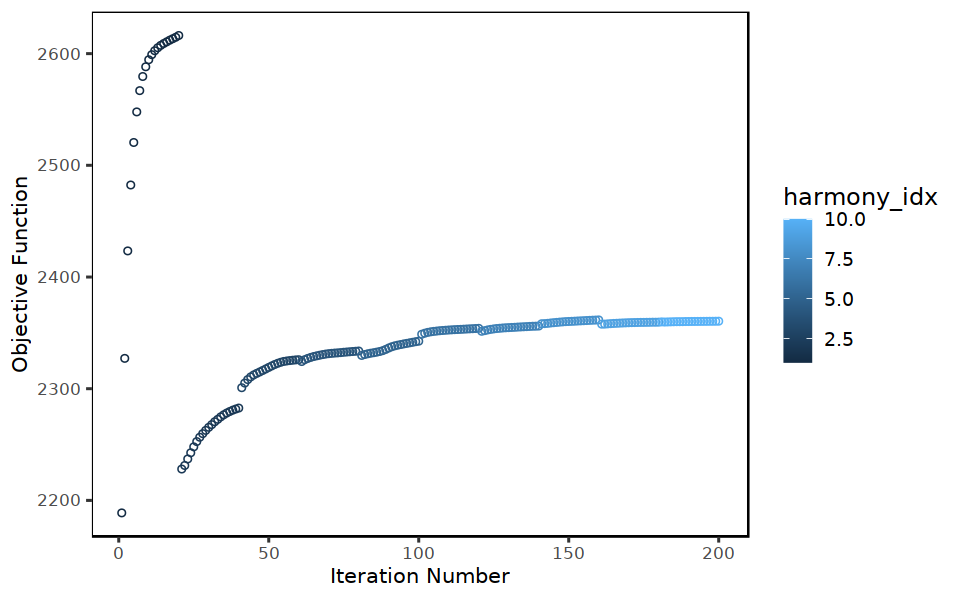

In [12]:
fig.size(5, 8)
set.seed(15)
obj_down <- create_object(
    obj_all$exprs_raw[, meta_down$CellID], 
    meta_down
) %>% 
    do_harmony(
        'LibraryID', theta=0.5, 
        max.iter.harmony=10, max.iter.cluster=20,
        epsilon.cluster = -Inf, epsilon.harmony = -Inf, 
        plot_convergence = TRUE, verbose = FALSE
    )


obj_down$U <- do_umap(t(obj_down$Z_cos), .spread = 2.0, .min_dist = 1.2)


## UMAPs

### Full data

In [ ]:
# p1 <- do_scatter(
#     obj_up$U$embedding, obj_up$meta_data, 
#     'LibraryID', 
#     quo(GroupID), nrow = 1, 
# #     'tissue_cell_type', quo(LibraryID), nrow = 1, 
#     pt_shape = 16, 
#     palette_use = tableau_color_pal()(6), #[c(2, 4)], 
#     do_labels = FALSE, no_guides = FALSE
# ) + 
#     labs(subtitle = 'Full datasets')

# p2 <- do_scatter(
#     obj_up$U$embedding, obj_up$meta_data, 
#     'tissue_cell_type', quo(GroupID), nrow = 1, 
# #     'LibraryID', quo(Cluster), nrow = 3, 
#     pt_shape = 16, 
# #     palette_use = tableau_color_pal()(2), 
#     do_labels = FALSE, no_guides = FALSE
# ) 



# fig.size(4, 12)
# (p1 | p2) + plot_layout(widths = c(1, 1))

### Down sampled

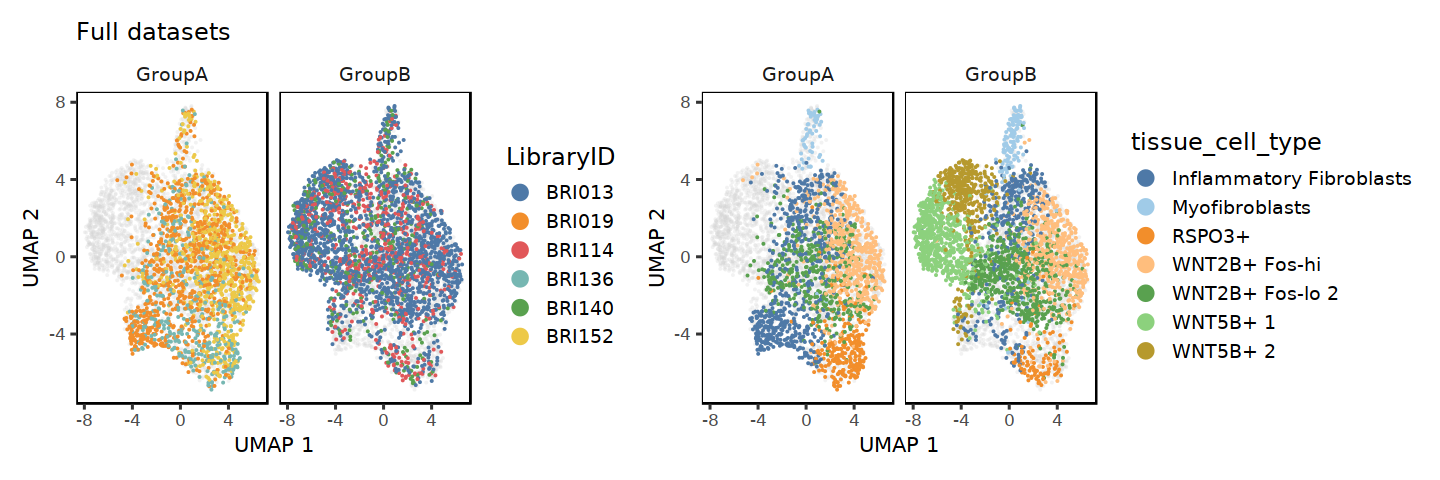

In [13]:
p3 <- do_scatter(
    obj_down$U$embedding, obj_down$meta_data, 
    'LibraryID', 
    quo(GroupID), nrow = 1, 
#     'tissue_cell_type', quo(LibraryID), nrow = 1, 
    pt_shape = 16, 
    palette_use = tableau_color_pal()(6), #[c(2, 4)], 
    do_labels = FALSE, no_guides = FALSE
) + 
    labs(subtitle = 'Full datasets')

p4 <- do_scatter(
    obj_down$U$embedding, obj_down$meta_data, 
    'tissue_cell_type', quo(GroupID), nrow = 1, 
#     'LibraryID', quo(Cluster), nrow = 3, 
    pt_shape = 16, 
#     palette_use = tableau_color_pal()(2), 
    do_labels = FALSE, no_guides = FALSE
) 


fig.size(4, 12)
(p3 | p4) + plot_layout(widths = c(1, 1))

## Can you detect a group-specific cluster? 

In [78]:
obj_down$adj <- obj_down$U$adj

In [99]:
obj_down <- do_cluster(obj_down, 'adj', .7, append_cols = FALSE)

0.7

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
New names:
* NA -> ...1

finished Louvain



In [155]:
cbind(obj_down$meta_data, obj_down$clusters_df) %>% 
    with(table(GroupID, res1)) 

        res1
GroupID    0   1   2   3   4   5   6   7
  GroupA 537  39 278 165 273 292 283  61
  GroupB 490 862 355 420 254 163 149 163

In [142]:
cbind(obj_down$meta_data, obj_down$clusters_df) %>% 
    with(prop.table(table(LibraryID, res1), 1)) %>% 
    data.table() %>% 
    left_join(unique(dplyr::select(obj_down$meta_data, LibraryID, GroupID))) %>% 
    split(.$res1) %>% 
    imap(function(.SD, .cluster) {
        t.test(N ~ GroupID, .SD) %>% broom::tidy() %>% cbind(Cluster = .cluster)
    }) %>% 
    bind_rows() %>% 
    arrange(p.value) %>% 
    dplyr::mutate(padj = p.adjust(p.value))


Joining, by = "LibraryID"



estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative,Cluster,padj
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
-0.28412633,0.01830477,0.30243110,-21.5086964,0.000410914,2.715191,-0.32877411,-0.2394785396,Welch Two Sample t-test,two.sided,1,0.003287312
-0.02969974,0.03003727,0.05973701,-3.5397226,0.024073567,3.994558,-0.05300779,-0.0063916920,Welch Two Sample t-test,two.sided,7,0.168514970
-0.06613380,0.08001207,0.14614587,-4.2853091,0.048793671,2.036286,-0.13141415,-0.0008534579,Welch Two Sample t-test,two.sided,3,0.292762026
0.11060214,0.17918703,0.06858489,1.2531363,0.327594045,2.184502,-0.24001195,0.4612162239,Welch Two Sample t-test,two.sided,6,1.000000000
0.09159206,0.15653675,0.06494469,1.2064208,0.347889613,2.060854,-0.22599585,0.4091799741,Welch Two Sample t-test,two.sided,5,1.000000000
0.03441535,0.13727701,0.10286166,1.0040601,0.392014197,2.883692,-0.07719844,0.1460291414,Welch Two Sample t-test,two.sided,4,1.000000000
0.10444697,0.26926272,0.16481575,0.9657688,0.430630903,2.131160,-0.33448635,0.5433802980,Welch Two Sample t-test,two.sided,0,1.000000000
0.03890335,0.12938238,0.09047903,0.7097044,0.517976286,3.903667,-0.11478372,0.1925904142,Welch Two Sample t-test,two.sided,2,1.000000000


Joining, by = "LibraryID"



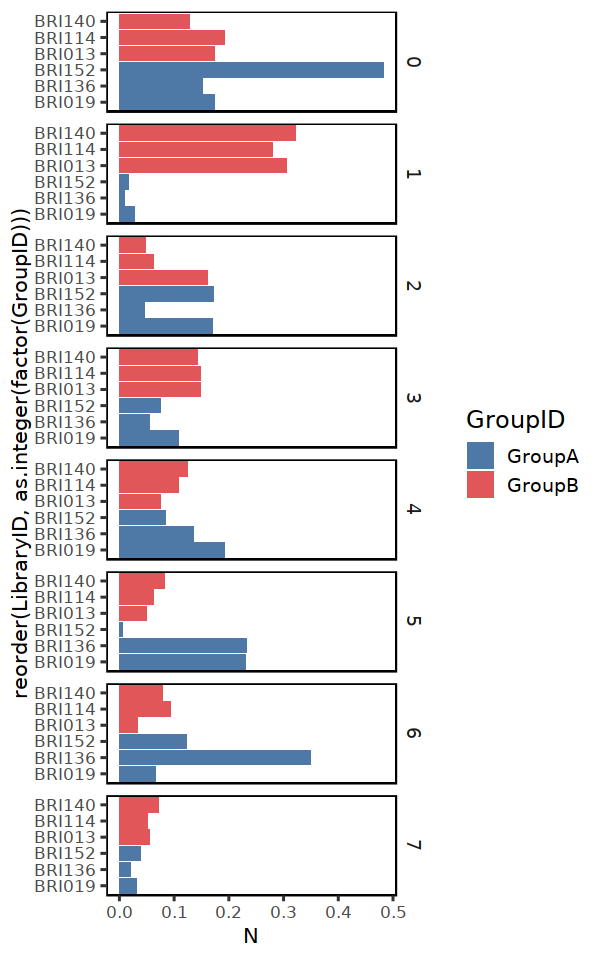

In [123]:
fig.size(8, 5)
cbind(obj_down$meta_data, obj_down$clusters_df) %>% 
    with(prop.table(table(LibraryID, res1), 1)) %>% 
    # with(table(LibraryID, res1)) %>% 
    data.table() %>% 
    left_join(unique(dplyr::select(obj_down$meta_data, LibraryID, GroupID))) %>% 
    ggplot(aes(reorder(LibraryID, as.integer(factor(GroupID))), N, fill = GroupID)) + 
        geom_bar(stat = 'identity') + 
        facet_grid(res1~., scales = 'free', space = 'free') + 
        scale_fill_manual(values = tableau_color_pal()(10)[c(1, 3)]) + 
        coord_flip() 


## Figure

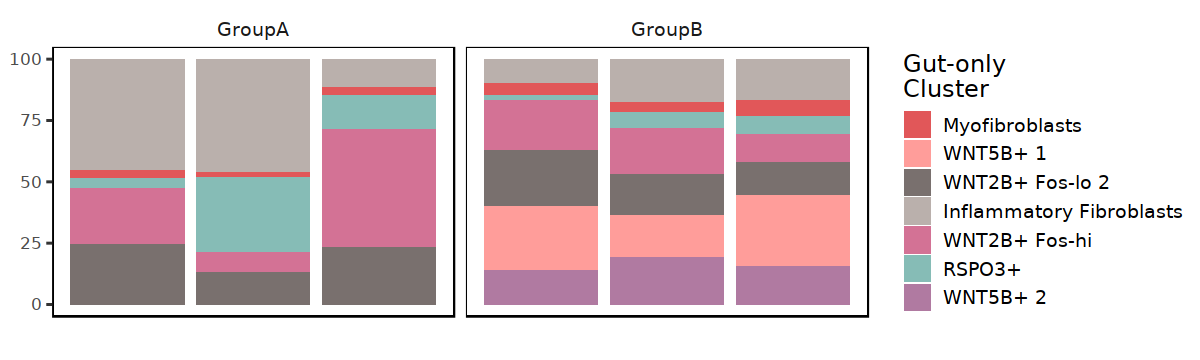

In [206]:
fig.size(3, 10)
p0 <- obj_down$meta_data %>% with(prop.table(table(LibraryID, GroupID, tissue_cell_type), 1)) %>% 
    data.table() %>% 
    subset(N > 0) %>% 
    ggplot(aes(LibraryID, 100 * N, fill = tissue_cell_type)) + 
        geom_bar(stat = 'identity') + 
        # coord_flip() + 
        labs(x = '', y = 'Relative Frequency', fill = 'Gut-only\nCluster') + 
        theme(
            axis.title.y = element_blank(), 
            # axis.text.y = element_blank(),
            # axis.ticks.y = element_blank()
            axis.text.x = element_blank(),
            axis.ticks.x = element_blank()
        ) + 
        scale_fill_manual(values = palette_global[unique(obj_down$meta_data$tissue_cell_type)]) + 
        facet_grid(.~GroupID, scales = 'free', space = 'free') + 
        # facet_grid(GroupID~., scales = 'free', space = 'free') + 
        # labs(subtitle = 'Downsampled datasets') + 
        # guides(fill = 'none') + 
        NULL
p0

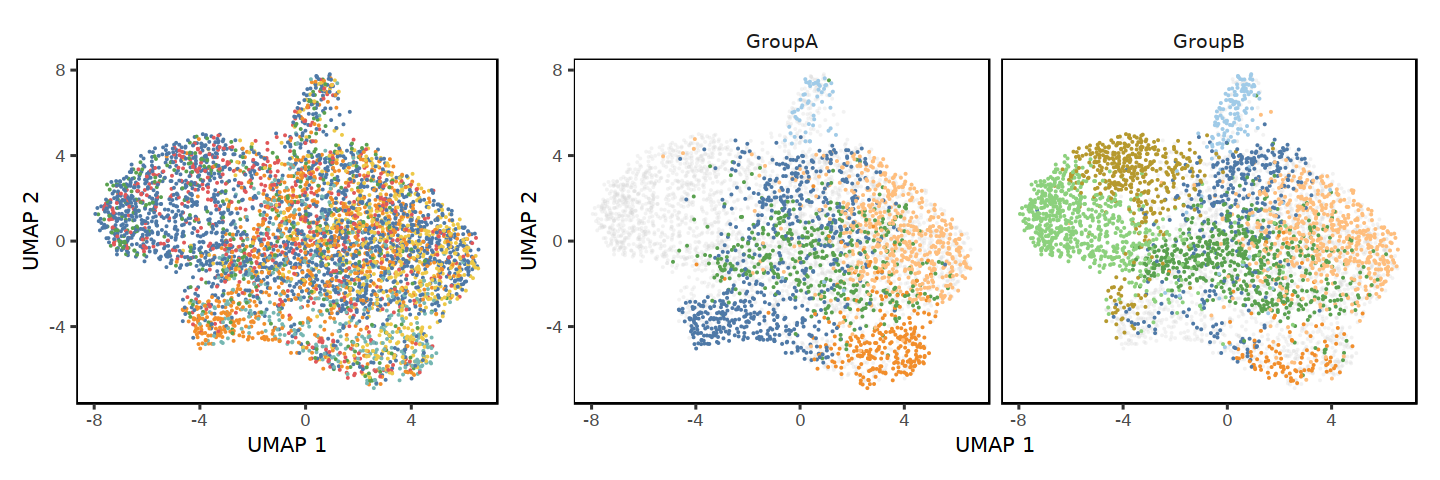

In [199]:
p1 <- do_scatter(
    obj_down$U$embedding, obj_down$meta_data, 
    'LibraryID', 
    pt_shape = 16, 
    palette_use = tableau_color_pal()(6), #[c(2, 4)], 
    do_labels = FALSE, no_guides = TRUE
)

p2 <- do_scatter(
    obj_down$U$embedding, obj_down$meta_data, 
    'tissue_cell_type', quo(GroupID), nrow = 1, 
    pt_shape = 16, 
    # palette_use = palette_global[unique(obj_down$meta_data$tissue_cell_type)], 
    do_labels = FALSE, no_guides = TRUE
) 


fig.size(4, 12)
(p1 | p2) + plot_layout(widths = c(1, 2))

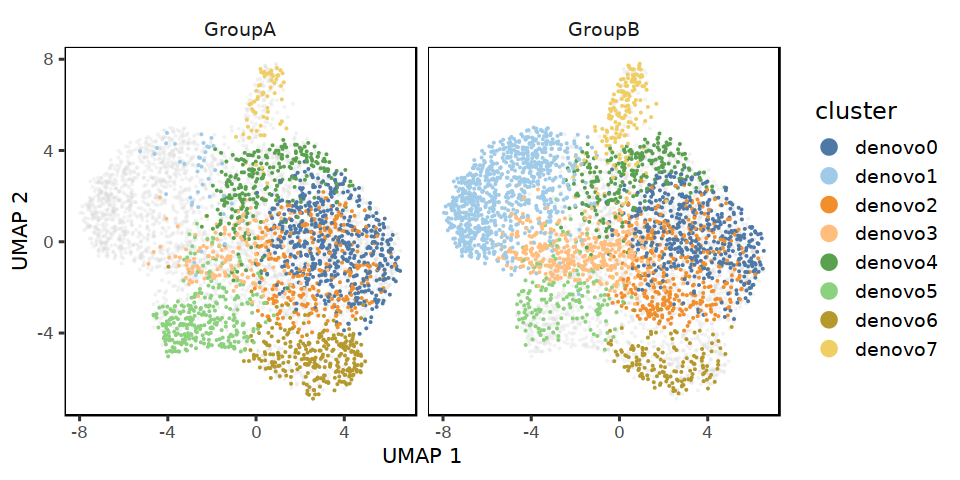

In [200]:
fig.size(4, 8)
p3 <- do_scatter(
    obj_down$U$embedding, cbind(obj_down$meta_data, cluster=paste0('denovo', obj_down$clusters_df$res1)), 'cluster', 
    pt_shape = 16, quo(GroupID), nrow=1,
    do_labels = FALSE, no_guides = FALSE
)
p3

Joining, by = "LibraryID"



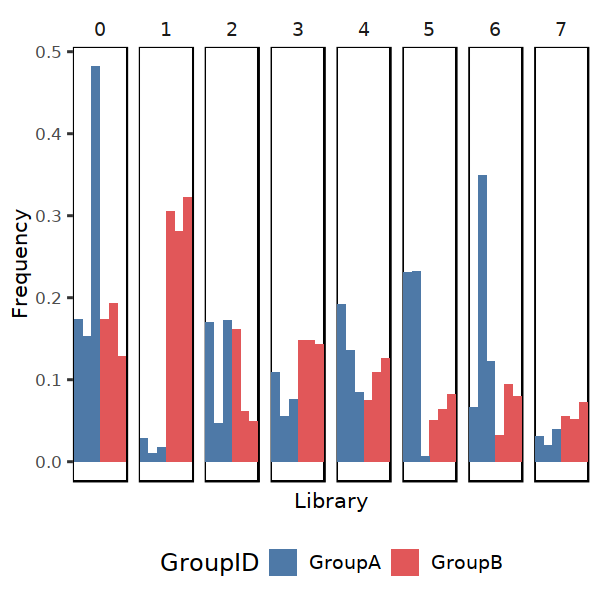

In [223]:
fig.size(5, 5)
p4 <- cbind(obj_down$meta_data, obj_down$clusters_df) %>% 
    with(prop.table(table(LibraryID, res1), 1)) %>% 
    data.table() %>% 
    left_join(unique(dplyr::select(obj_down$meta_data, LibraryID, GroupID))) %>% 
    # subset(res1 == '1') %>% 
    # dplyr::mutate(res1 = paste0('denovo', res1)) %>% 
    ggplot(aes(reorder(LibraryID, as.integer(factor(GroupID))), N, fill = GroupID)) + 
        geom_bar(stat = 'identity') + 
        facet_grid(.~res1, scales = 'free', space = 'free') + 
        # facet_grid(res1~., scales = 'free', space = 'free') + 
        scale_fill_manual(values = tableau_color_pal()(10)[c(1, 3)]) + 
        # coord_flip() + 
        labs(y = 'Frequency', x = 'Library') + 
        theme(
            # axis.text.y = element_blank(),
            # axis.ticks.y = element_blank()
            axis.text.x = element_blank(),
            axis.ticks.x = element_blank(),
            legend.position = 'bottom'
        )
p4

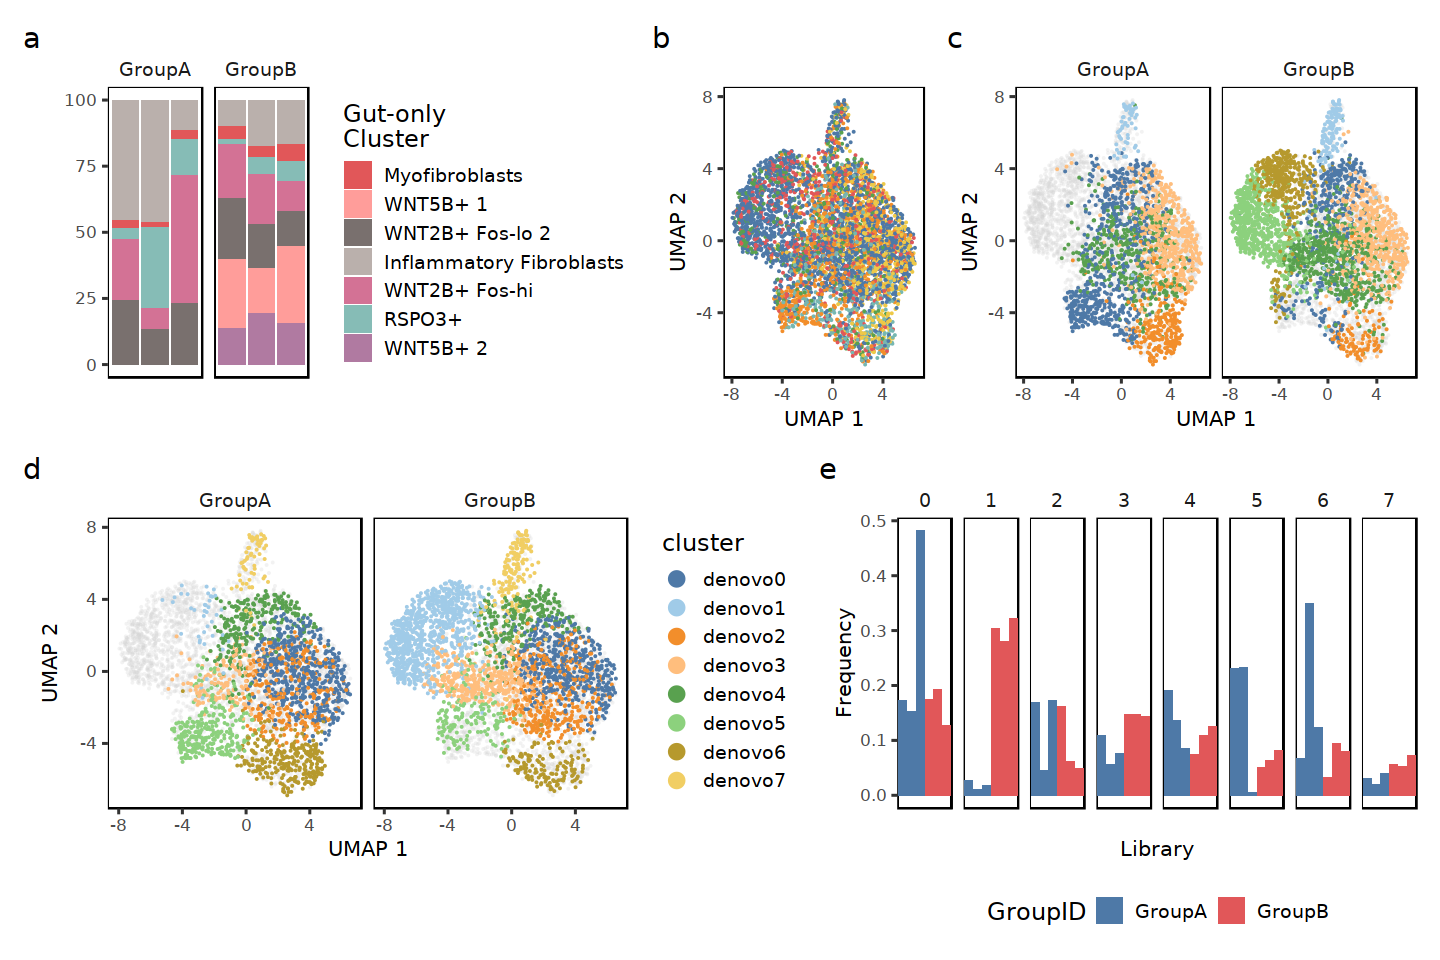

In [224]:
fig.size(8, 12)
(
    (
        (p0 | p1 | p2) + plot_layout(width = c(1, 1, 2))
    ) / 
    (
        (p3 | p4) + plot_layout(width = c(1, 1))
    ) 
) + 
plot_annotation(tag_levels = 'a')


## Cache

In [195]:
# saveRDS(obj_up, '../../data/revision2/R1C07_objup.rds')
saveRDS(obj_down, '../../data/revision2/R1C07_objdown.rds')